### **Denoising Dirty Documents**
![](https://miro.medium.com/max/1838/1*wb4C1_RvYhQA3netynhrDg.png)

* Getting the Data from Kaggle.
    * Downloading and knowing about the data.
* Setting up the project directory.
* Preparing the data:
    * Preparing custom datasets and getting the iterable data loaders.
* Building the autoencoder neural network.
* Training the data.
* Testing the data


### Kaggle Dataset - [Denoising Dirty Documents](https://www.kaggle.com/c/denoising-dirty-documents/data)
---
Apart from the sampleSubmission.csv we have three zip files.

* `train.zip` contains the images that we will train our deep learning autoencoder on. These images contain text to which noise has been added. Our aim is to build an autoencoder neural network that will denoise those images.
* `test.zip` contains the images that we will use to test our neural network once it has been trained. We will try to get clean images as the output by cleaning the noise from the test images.
* `train_cleaned.zip` contains the same images as the train images but without the noise. We will use these images as targets to train our network.

### How to Download kaggle Dataset

1. Install : `pip install --upgrade opendatasets`
2. `import opendatasets as od`
3. `od.download("https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset")`
4. On executing the above line, it will prompt for Kaggle username. Kaggle username can be fetched from the Account tab of the My Profile section.
5. On entering the username, it will prompt for Kaggle Key. Again, go to the account tab of the My Profile section and click on Create New API Token. This will download a kaggle.json file.
![](https://camo.githubusercontent.com/b731cd69440cb8110c14de011461bf34ea097e952e06a8ebb2b06687221b233c/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3837352f312a663934473664586d2d386352785835464654437179672e706e67)

![](https://camo.githubusercontent.com/88e8b13f0631cac85cc1f4df97d4971f0af59887e4d46b0d851d7a228692bfc3/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3837352f312a726873474b546864677877556f736b614143536c77412e706e67)

for more details follow the page : https://github.com/JovianML/opendatasets

### Seting Up Repository

```
|--denoising-dirty-documents
|    |-test
|    |-train
|    |-train_cleaned
```

### **1.Import Libraries**

In [41]:
# torch laoded...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# torchvision laoded...!!!
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchsummary import summary

# other libs loaded...!!!
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import os
from tqdm import tqdm


##### Some of the important modules that we have imported are:

* `torchvision`: helps in carrying out many deep learning related computer vision tasks easily.
* `Dataset`: the Dataset class will help us create our custom dataset for the images that we have. We will need to override two of its functions, `__len__()`, and `__getitem__`().
* `DataLoader`: this class will help us to create iterable data loaders that we can feed into our autoencoder network for training and testing.

----------------Noisy Image----------------
(420, 540, 3)


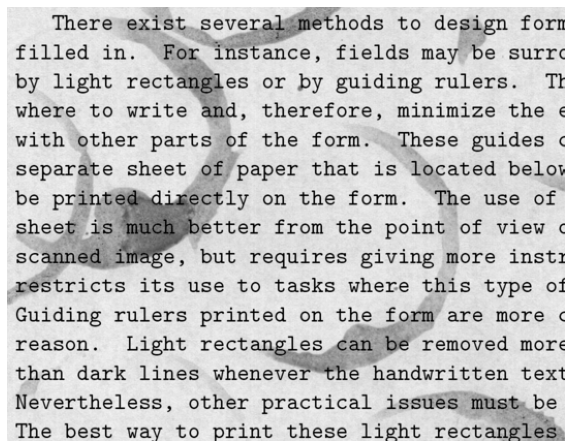

----------------Clean Image----------------
(420, 540, 3)


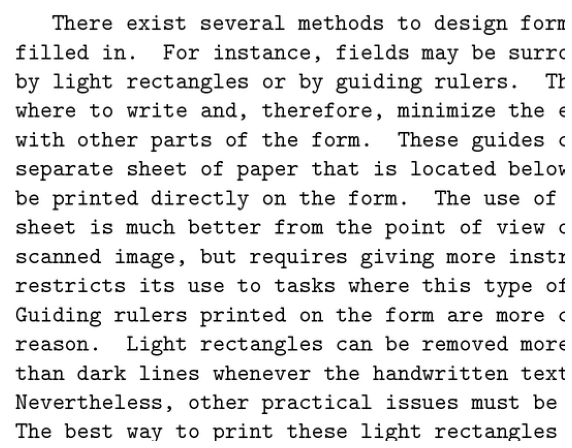

In [3]:
def show_image(path):
    plt.figure(figsize=(10,10))
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

print("----------------Noisy Image----------------")    
show_image(r'D:\ashishpatel26_github\Pytorch Learning\denoising-dirty-documents\train\206.png')
print("----------------Clean Image----------------")    
show_image(r'D:\ashishpatel26_github\Pytorch Learning\denoising-dirty-documents\train_cleaned\206.png')

### **2.Preparing the Custom Dataset and DataLoader**

* In the above code block, we are using the python `glob` module to get the `.png` images from all the thee directories. So, `TRAIN_IMAGES`, `TRAIN_CLEAN_IMAGES`, and `TEST_IMAGES` will contain the names of path from train, train_cleaned, and test directories respectively. They are all lists that just contain the names of the images.

In [4]:
import glob
TRAIN_IMAGES = glob.glob('./denoising-dirty-documents/train/*.png')
TRAIN_CLEAN_IMAGES = glob.glob('./denoising-dirty-documents/train_cleaned/*.png')
TEST_IMAGES = glob.glob('./denoising-dirty-documents/test/*.png')

### **3.Resizing and Saving Pixel Values**

In [5]:
def get_data(path):
    images = []
    for i, image in tqdm(enumerate(path)):
        image = cv2.imread(image)
        image = cv2.resize(image, (256, 256))
        image = np.reshape(image, image.shape[0] * image.shape[1] * image.shape[2])
        images.append(image)
    print("Total Images : ", len(images))
    return images

x_train = get_data(TRAIN_IMAGES)
y_train = get_data(TRAIN_CLEAN_IMAGES)
x_test = get_data(TEST_IMAGES)

0it [00:00, ?it/s]

Total Images :  144


0it [00:00, ?it/s]

Total Images :  144


0it [00:00, ?it/s]

Total Images :  72


### **4.Defining Constant and Image Transformation**

In [86]:
# copnstants
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 2

In [7]:
# Data transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
    ])

### **5.Writing Custom Dataset Class**

In [62]:
# prepare the dataset and the dataloader
class ImageData(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        data = np.asarray(data).astype(np.uint8).reshape((256, 256, 3))
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            labels = self.y[i][:]
            labels = np.asarray(labels).astype(np.uint8).reshape((256, 256, 3))
            labels = self.transforms(labels)
            return (data, labels)
        else:
            return data

In [63]:
# load the data
trainData = ImageData(x_train, y_train, transform)
test = ImageData(x_test, transforms = transform)

In [64]:
trainLoader = DataLoader(trainData, batch_size = BATCH_SIZE, shuffle = True)
testLoader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

### **6. Helper Function**

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dir():
    image_dir = './denoising-dirty-documents/Saved_images'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    return image_dir
        
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 256, 256)
    save_image(img, name)
    
create_dir()

'./denoising-dirty-documents/Saved_images'

In [66]:
for batch in trainLoader:
    x, y = batch
    print(x[0].shape)
    print(y[0].shape)
    break    

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


### **7.Building AutoEncoder Network Archiecture**

In [67]:
# The autoencoder network
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # encoder layers
        self.enc1 = nn.Conv2d(3, 512, 3, padding=1)
        self.enc2 = nn.Conv2d(512, 256, 3, padding=1)
        self.enc3 = nn.Conv2d(256, 128, 3, padding=1)
        self.enc4 = nn.Conv2d(128, 64, 3, padding=1)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec2 = nn.ConvTranspose2d(64, 128, 2, stride=2)
        self.dec3 = nn.ConvTranspose2d(128, 256, 2, stride=2)
        self.dec4 = nn.ConvTranspose2d(256, 512, 2, stride=2)
        self.out = nn.Conv2d(512,3, 3, padding=1)
        
        # batch normalization
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        # encoder
        x = self.pool(self.bn1(F.relu(self.enc1(x))))
        x = self.pool(self.bn2(F.relu(self.enc2(x))))
        x = self.pool(self.bn3(F.relu(self.enc3(x))))
        x = self.pool(self.bn4(F.relu(self.enc4(x))))
        
        # decoder
        x = self.bn4(F.relu(self.dec1(x)))  
        x = self.bn3(F.relu(self.dec2(x)))
        x = self.bn2(F.relu(self.dec3(x)))
        x = self.bn1(F.relu(self.dec4(x)))
        x = torch.sigmoid(self.out(x))
        return x
    
net = AutoEncoder().to(device)
print(net)

AutoEncoder(
  (enc1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec3): ConvTranspose2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(512, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [68]:
print(summary(net, (3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 512, 256, 256]       14,336
├─BatchNorm2d: 1-2                       [-1, 512, 256, 256]       1,024
├─MaxPool2d: 1-3                         [-1, 512, 128, 128]       --
├─Conv2d: 1-4                            [-1, 256, 128, 128]       1,179,904
├─BatchNorm2d: 1-5                       [-1, 256, 128, 128]       512
├─MaxPool2d: 1-6                         [-1, 256, 64, 64]         --
├─Conv2d: 1-7                            [-1, 128, 64, 64]         295,040
├─BatchNorm2d: 1-8                       [-1, 128, 64, 64]         256
├─MaxPool2d: 1-9                         [-1, 128, 32, 32]         --
├─Conv2d: 1-10                           [-1, 64, 32, 32]          73,792
├─BatchNorm2d: 1-11                      [-1, 64, 32, 32]          128
├─MaxPool2d: 1-12                        [-1, 64, 16, 16]          --
├─ConvTranspose2d: 1-13                  [-1, 64, 32, 32]  

### **8.Loss Function and Optimizer.**

In [69]:
# Loss and optimizer
loss_fn = nn.MSELoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

### **9.Training and Testing Function**

In [72]:
def train(net, trainLoader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description("Epoch {}".format(epoch+1))
            for data in tepoch:
                img = data[0].to(device)
                labels = data[1].to(device)
                optimizer.zero_grad() # zero the gradient buffers
                outputs = net(img) # forward propagation
                loss = loss_fn(outputs, labels) # calculate loss
                loss.backward() # backward propagation
                optimizer.step() # update weights
                running_loss += loss.item() # cost of each batch
                tepoch.set_postfix(loss=loss)
                
            loss = running_loss / len(trainLoader)
            train_loss.append(loss)
            print('[Epoch %d] loss: %.3f' %(epoch + 1, running_loss/len(trainLoader)))
    
            if epoch % 2 == 0:
                save_decoded_image(outputs.cpu().data, name=f'./denoising-dirty-documents/Saved_images/denoised{epoch}.png')
    
    return train_loss

def test(net, testLoader):
    test_loss = []
    for data in testLoader:
        img = data.to(device)
        outputs = net(img)
        save_decoded_image(outputs.cpu().data, name='./denoising-dirty-documents/Saved_images/denoised_test.png')    

In [87]:
train_loss = train(net, trainLoader, NUM_EPOCHS)
test(net, testLoader)

Epoch 1: 100%|██████████| 72/72 [00:10<00:00,  6.66batch/s, loss=tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 1] loss: 0.036


Epoch 2: 100%|██████████| 72/72 [00:10<00:00,  6.69batch/s, loss=tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 2] loss: 0.036


Epoch 3: 100%|██████████| 72/72 [00:10<00:00,  6.78batch/s, loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 3] loss: 0.036


Epoch 4: 100%|██████████| 72/72 [00:10<00:00,  6.74batch/s, loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 4] loss: 0.035


Epoch 5: 100%|██████████| 72/72 [00:10<00:00,  6.74batch/s, loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 5] loss: 0.036


Epoch 6: 100%|██████████| 72/72 [00:10<00:00,  6.77batch/s, loss=tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 6] loss: 0.035


Epoch 7: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 7] loss: 0.034


Epoch 8: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 8] loss: 0.034


Epoch 9: 100%|██████████| 72/72 [00:10<00:00,  6.88batch/s, loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 9] loss: 0.033


Epoch 10: 100%|██████████| 72/72 [00:10<00:00,  6.89batch/s, loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 10] loss: 0.032


Epoch 11: 100%|██████████| 72/72 [00:10<00:00,  6.90batch/s, loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 11] loss: 0.032


Epoch 12: 100%|██████████| 72/72 [00:10<00:00,  6.94batch/s, loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 12] loss: 0.030


Epoch 13: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 13] loss: 0.029


Epoch 14: 100%|██████████| 72/72 [00:10<00:00,  6.90batch/s, loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 14] loss: 0.028


Epoch 15: 100%|██████████| 72/72 [00:10<00:00,  6.91batch/s, loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 15] loss: 0.027


Epoch 16: 100%|██████████| 72/72 [00:10<00:00,  6.91batch/s, loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 16] loss: 0.026


Epoch 17: 100%|██████████| 72/72 [00:10<00:00,  6.93batch/s, loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 17] loss: 0.025


Epoch 18: 100%|██████████| 72/72 [00:10<00:00,  6.89batch/s, loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 18] loss: 0.023


Epoch 19: 100%|██████████| 72/72 [00:10<00:00,  6.92batch/s, loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 19] loss: 0.022


Epoch 20: 100%|██████████| 72/72 [00:10<00:00,  6.90batch/s, loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 20] loss: 0.021


Epoch 21: 100%|██████████| 72/72 [00:10<00:00,  6.92batch/s, loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 21] loss: 0.020


Epoch 22: 100%|██████████| 72/72 [00:10<00:00,  6.91batch/s, loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 22] loss: 0.019


Epoch 23: 100%|██████████| 72/72 [00:10<00:00,  6.90batch/s, loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 23] loss: 0.019


Epoch 24: 100%|██████████| 72/72 [00:10<00:00,  6.78batch/s, loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 24] loss: 0.018


Epoch 25: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 25] loss: 0.017


Epoch 26: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 26] loss: 0.016


Epoch 27: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 27] loss: 0.015


Epoch 28: 100%|██████████| 72/72 [00:10<00:00,  6.82batch/s, loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 28] loss: 0.014


Epoch 29: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 29] loss: 0.013


Epoch 30: 100%|██████████| 72/72 [00:10<00:00,  6.81batch/s, loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 30] loss: 0.014


Epoch 31: 100%|██████████| 72/72 [00:10<00:00,  6.82batch/s, loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 31] loss: 0.013


Epoch 32: 100%|██████████| 72/72 [00:10<00:00,  6.82batch/s, loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 32] loss: 0.013


Epoch 33: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 33] loss: 0.012


Epoch 34: 100%|██████████| 72/72 [00:10<00:00,  6.83batch/s, loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 34] loss: 0.011


Epoch 35: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 35] loss: 0.010


Epoch 36: 100%|██████████| 72/72 [00:10<00:00,  6.83batch/s, loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 36] loss: 0.010


Epoch 37: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 37] loss: 0.010


Epoch 38: 100%|██████████| 72/72 [00:10<00:00,  6.88batch/s, loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 38] loss: 0.009


Epoch 39: 100%|██████████| 72/72 [00:10<00:00,  6.87batch/s, loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 39] loss: 0.009


Epoch 40: 100%|██████████| 72/72 [00:10<00:00,  6.83batch/s, loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 40] loss: 0.009


Epoch 41: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 41] loss: 0.009


Epoch 42: 100%|██████████| 72/72 [00:10<00:00,  6.83batch/s, loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 42] loss: 0.008


Epoch 43: 100%|██████████| 72/72 [00:10<00:00,  6.87batch/s, loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 43] loss: 0.008


Epoch 44: 100%|██████████| 72/72 [00:10<00:00,  6.84batch/s, loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 44] loss: 0.008


Epoch 45: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 45] loss: 0.007


Epoch 46: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 46] loss: 0.007


Epoch 47: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 47] loss: 0.007


Epoch 48: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 48] loss: 0.008


Epoch 49: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 49] loss: 0.006


Epoch 50: 100%|██████████| 72/72 [00:09<00:00,  7.25batch/s, loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 50] loss: 0.007


Epoch 51: 100%|██████████| 72/72 [00:09<00:00,  7.30batch/s, loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 51] loss: 0.006


Epoch 52: 100%|██████████| 72/72 [00:10<00:00,  7.19batch/s, loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 52] loss: 0.006


Epoch 53: 100%|██████████| 72/72 [00:09<00:00,  7.54batch/s, loss=tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 53] loss: 0.006


Epoch 54: 100%|██████████| 72/72 [00:09<00:00,  7.45batch/s, loss=tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 54] loss: 0.006


Epoch 55: 100%|██████████| 72/72 [00:09<00:00,  7.48batch/s, loss=tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 55] loss: 0.006


Epoch 56: 100%|██████████| 72/72 [00:09<00:00,  7.51batch/s, loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 56] loss: 0.006


Epoch 57: 100%|██████████| 72/72 [00:09<00:00,  7.55batch/s, loss=tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 57] loss: 0.006


Epoch 58: 100%|██████████| 72/72 [00:09<00:00,  7.56batch/s, loss=tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 58] loss: 0.005


Epoch 59: 100%|██████████| 72/72 [00:09<00:00,  7.55batch/s, loss=tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 59] loss: 0.005


Epoch 60: 100%|██████████| 72/72 [00:09<00:00,  7.56batch/s, loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 60] loss: 0.005


Epoch 61: 100%|██████████| 72/72 [00:09<00:00,  7.52batch/s, loss=tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 61] loss: 0.007


Epoch 62: 100%|██████████| 72/72 [00:09<00:00,  7.45batch/s, loss=tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 62] loss: 0.005


Epoch 63: 100%|██████████| 72/72 [00:09<00:00,  7.51batch/s, loss=tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 63] loss: 0.006


Epoch 64: 100%|██████████| 72/72 [00:09<00:00,  7.31batch/s, loss=tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 64] loss: 0.005


Epoch 65: 100%|██████████| 72/72 [00:10<00:00,  6.93batch/s, loss=tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 65] loss: 0.005


Epoch 66: 100%|██████████| 72/72 [00:09<00:00,  7.41batch/s, loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 66] loss: 0.005


Epoch 67: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 67] loss: 0.005


Epoch 68: 100%|██████████| 72/72 [00:09<00:00,  7.34batch/s, loss=tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 68] loss: 0.004


Epoch 69: 100%|██████████| 72/72 [00:09<00:00,  7.34batch/s, loss=tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 69] loss: 0.005


Epoch 70: 100%|██████████| 72/72 [00:10<00:00,  7.01batch/s, loss=tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 70] loss: 0.005


Epoch 71: 100%|██████████| 72/72 [00:09<00:00,  7.55batch/s, loss=tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 71] loss: 0.005


Epoch 72: 100%|██████████| 72/72 [00:10<00:00,  7.16batch/s, loss=tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 72] loss: 0.004


Epoch 73: 100%|██████████| 72/72 [00:09<00:00,  7.51batch/s, loss=tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 73] loss: 0.004


Epoch 74: 100%|██████████| 72/72 [00:09<00:00,  7.33batch/s, loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 74] loss: 0.004


Epoch 75: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 75] loss: 0.004


Epoch 76: 100%|██████████| 72/72 [00:09<00:00,  7.58batch/s, loss=tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 76] loss: 0.004


Epoch 77: 100%|██████████| 72/72 [00:09<00:00,  7.59batch/s, loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 77] loss: 0.005


Epoch 78: 100%|██████████| 72/72 [00:09<00:00,  7.58batch/s, loss=tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 78] loss: 0.005


Epoch 79: 100%|██████████| 72/72 [00:09<00:00,  7.59batch/s, loss=tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 79] loss: 0.006


Epoch 80: 100%|██████████| 72/72 [00:09<00:00,  7.58batch/s, loss=tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 80] loss: 0.004


Epoch 81: 100%|██████████| 72/72 [00:09<00:00,  7.58batch/s, loss=tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 81] loss: 0.004


Epoch 82: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 82] loss: 0.004


Epoch 83: 100%|██████████| 72/72 [00:09<00:00,  7.60batch/s, loss=tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 83] loss: 0.004


Epoch 84: 100%|██████████| 72/72 [00:09<00:00,  7.60batch/s, loss=tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 84] loss: 0.004


Epoch 85: 100%|██████████| 72/72 [00:09<00:00,  7.50batch/s, loss=tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 85] loss: 0.004


Epoch 86: 100%|██████████| 72/72 [00:09<00:00,  7.53batch/s, loss=tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 86] loss: 0.004


Epoch 87: 100%|██████████| 72/72 [00:09<00:00,  7.60batch/s, loss=tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 87] loss: 0.004


Epoch 88: 100%|██████████| 72/72 [00:09<00:00,  7.54batch/s, loss=tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 88] loss: 0.003


Epoch 89: 100%|██████████| 72/72 [00:09<00:00,  7.59batch/s, loss=tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 89] loss: 0.004


Epoch 90: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 90] loss: 0.004


Epoch 91: 100%|██████████| 72/72 [00:09<00:00,  7.60batch/s, loss=tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 91] loss: 0.004


Epoch 92: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 92] loss: 0.004


Epoch 93: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 93] loss: 0.004


Epoch 94: 100%|██████████| 72/72 [00:09<00:00,  7.57batch/s, loss=tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 94] loss: 0.004


Epoch 95: 100%|██████████| 72/72 [00:09<00:00,  7.40batch/s, loss=tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 95] loss: 0.004


Epoch 96: 100%|██████████| 72/72 [00:09<00:00,  7.42batch/s, loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 96] loss: 0.004


Epoch 97: 100%|██████████| 72/72 [00:09<00:00,  7.47batch/s, loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 97] loss: 0.005


Epoch 98: 100%|██████████| 72/72 [00:09<00:00,  7.47batch/s, loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 98] loss: 0.006


Epoch 99: 100%|██████████| 72/72 [00:09<00:00,  7.46batch/s, loss=tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 99] loss: 0.004


Epoch 100: 100%|██████████| 72/72 [00:09<00:00,  7.47batch/s, loss=tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)]


[Epoch 100] loss: 0.003


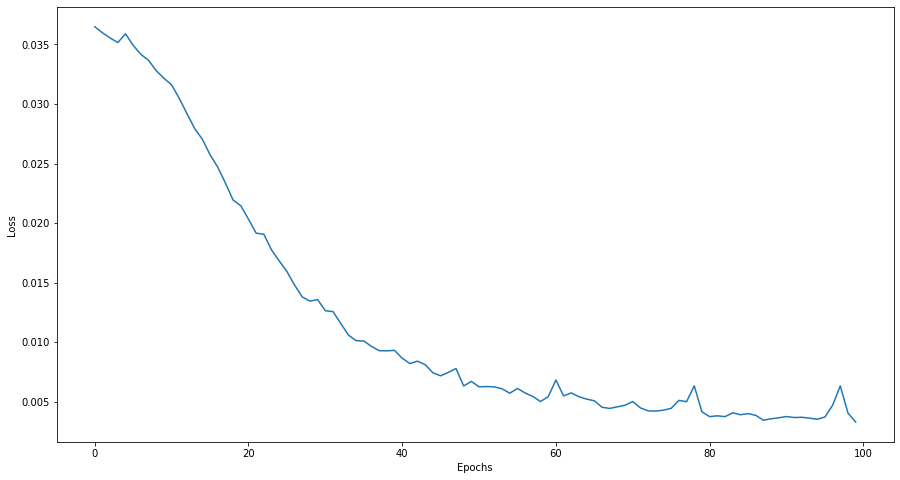

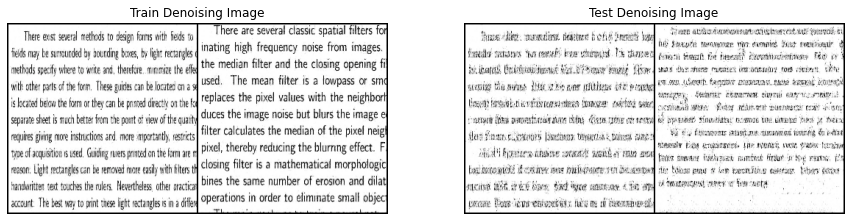

In [91]:
plt.figure(figsize=(15,8))
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread('./denoising-dirty-documents/Saved_images/denoised98.png'))
plt.title('Train Denoising Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.imread('./denoising-dirty-documents/Saved_images/denoised_test.png'))
plt.title('Test Denoising Image')
plt.axis('off')
plt.show()